In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
import numpy as np
import random
from einops import rearrange
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, ExponentialLR, LinearLR
from collections import deque
import math
import warnings
import copy


def set_deterministic_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_deterministic_seed(42)

In [2]:
batch_size = 128
epochs     = 50

mean = (0.4914, 0.4822, 0.4465)
std  = (0.247, 0.243, 0.261)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
test_dataset = datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=4)


100%|██████████| 169M/169M [00:03<00:00, 48.5MB/s]


In [3]:
model = resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Linear(512, 100)
model2 = copy.deepcopy(model)
model3 = copy.deepcopy(model)
model4 = copy.deepcopy(model)

model = model.to("cuda:0")
model2 = model2.to("cuda:0")
model3 = model3.to("cuda:0")
model4 = model4.to("cuda:0")

model2.load_state_dict(model.state_dict())
model3.load_state_dict(model.state_dict())
model4.load_state_dict(model.state_dict())

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum = 0.9, weight_decay = 1e-4)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-1, momentum = 0.9, weight_decay = 1e-4)
optimizer3 = optim.SGD(model3.parameters(), lr=1e-1, momentum = 0.9, weight_decay = 1e-4)
optimizer4 = optim.SGD(model4.parameters(), lr=1e-1, momentum = 0.9, weight_decay = 1e-4)

print(sum(param.numel() for param in model.parameters() if param.requires_grad))

11220132


In [4]:
def calculate_transformed_ratio_sigma(loss_history, volatility_window_N, weight_const, min_loss_val=1e-8):
    data = np.maximum(np.array(loss_history), min_loss_val)
    required_data = volatility_window_N + 1
    if len(data) < required_data:
        return 1.0

    log_returns = np.log(data[1:] / data[:-1])
    sigma_all_val = np.std(log_returns, ddof=1)
    recent_log_returns_N = log_returns[-volatility_window_N:]
    sigma_n_val = np.std(recent_log_returns_N, ddof=1)

    if sigma_n_val == 0 or math.isnan(sigma_n_val) or math.isinf(sigma_n_val) or \
       math.isnan(sigma_all_val) or math.isinf(sigma_all_val):
        return 1.0

    ratio_sigma_val = sigma_all_val / sigma_n_val
    
    signed_deviation = ratio_sigma_val - 1.0
    abs_deviation = np.abs(signed_deviation)
    scaled_abs_deviation = abs_deviation * weight_const
    
    log_transformed_deviation = np.log1p(scaled_abs_deviation) 
    
    final_signed_log_deviation = np.copysign(log_transformed_deviation, signed_deviation)
    
    final_multiplier = 1.0 + final_signed_log_deviation
    
    if math.isnan(final_multiplier) or math.isinf(final_multiplier):
        return 1.0
        
    return final_multiplier

class VolatilityRatioScheduler(_LRScheduler):
    def __init__(self, optimizer,
                 volatility_window_N,
                 weight_const,
                 T_max,
                 eta_min = 0,
                 max_loss_history_len=None,
                 last_epoch=-1, verbose=False):
        
        if volatility_window_N < 2:
            raise ValueError("volatility_window_N must be at least 2.")
        self.T_max = T_max
        self.volatility_window_N = volatility_window_N
        self.scheduler_update_interval = volatility_window_N
        self.weight_const = weight_const
        self.loss_history = []
        if max_loss_history_len is None:
            self.max_loss_history_len = volatility_window_N * 10
        else:
            self.max_loss_history_len = max_loss_history_len
        self.eta_min = eta_min
        
        super(VolatilityRatioScheduler, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            return [group['lr'] for group in self.optimizer.param_groups]
            
        if self.last_epoch % self.scheduler_update_interval != 0:
            return [group['lr'] for group in self.optimizer.param_groups]
        
        cosmul = (1 + math.cos(math.pi * (self.last_epoch) / self.T_max)) / (1 + math.cos(math.pi * (self.last_epoch - self.scheduler_update_interval) / self.T_max))
        multiplier = calculate_transformed_ratio_sigma(
            loss_history=self.loss_history,
            volatility_window_N=self.volatility_window_N,
            weight_const=self.weight_const
        ) * cosmul
        print(f"LR Scheduler: Update at end of step {self.last_epoch}, "
              f"Old LRs: {[g['lr'] for g in self.optimizer.param_groups]}, "
              f"New LRs: {[max(self.eta_min, g['lr'] * multiplier) for g in self.optimizer.param_groups]}, "
              f"Cosine: {cosmul:.4f}, "
              f"Calculated LR Multiplier: {multiplier:.4f}")
        
        return [max(self.eta_min, g['lr'] * multiplier) for g in self.optimizer.param_groups]

    def step(self, loss_value=None, epoch=None):
        if loss_value is not None:
            loss_val_float = float(loss_value)
            if math.isnan(loss_val_float) or math.isinf(loss_val_float):
                warnings.warn(f"NaN or Inf loss_value ({loss_value}) passed to scheduler.step(). Skipping update for this loss.")
            else:
                self.loss_history.append(loss_val_float)
            
            if self.max_loss_history_len is not None and len(self.loss_history) > self.max_loss_history_len:
                num_to_remove = len(self.loss_history) - self.max_loss_history_len
                self.loss_history = self.loss_history[num_to_remove:]
        
        super(VolatilityRatioScheduler, self).step(epoch)


scheduler = CosineAnnealingLR(optimizer,
                              T_max = (epochs - 1) * len(train_loader),
                              eta_min = 1e-4)

scheduler2 = VolatilityRatioScheduler(optimizer2,
                                      volatility_window_N = 50,
                                      weight_const = 0.05,
                                      T_max = epochs * len(train_loader),
                                      eta_min = 1e-4)

scheduler3 = ExponentialLR(optimizer3, gamma = 0.95)

scheduler4 = ReduceLROnPlateau(optimizer4, 
                               mode = "max",
                               factor = 0.5,
                               min_lr = 1e-4)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, total_iters=len(train_loader))
warmup_scheduler3 = LinearLR(optimizer3, start_factor=0.01, total_iters=len(train_loader))
warmup_scheduler4 = LinearLR(optimizer4, start_factor=0.01, total_iters=len(train_loader))

In [6]:
def evaluate(model, device):
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100. * correct / total
    model.train()
    return accuracy

In [7]:
accs = {"cosine": [], "gbm": [], "exp": [], "plateau": []}
losses = {"cosine": [], "gbm": [], "exp": [], "plateau": []}
lrs = []
model.train()
model2.train()
model3.train()
model4.train()
i = 0
accs["cosine"].append(evaluate(model, "cuda:0"))
accs["gbm"].append(evaluate(model2, "cuda:0"))
accs["exp"].append(evaluate(model3, "cuda:0"))
accs["plateau"].append(evaluate(model4, "cuda:0"))
print("total steps:", len(train_loader) * (epochs - 1))
print("step:", i, "\tcosine:", accs["cosine"][-1], "\tgbm:", accs["gbm"][-1], "\texp:", accs["exp"][-1], "\tplateau:", accs["plateau"][-1])
for epoch in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to("cuda:0"), labels.to("cuda:0")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses["cosine"].append(loss.item())
        loss.backward()
        optimizer.step()
        if epoch == 0:
            warmup_scheduler.step()
        else:
            scheduler.step()

        optimizer3.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        losses["exp"].append(loss.item())
        loss.backward()
        optimizer3.step()
        if epoch == 0:
            warmup_scheduler3.step()

        optimizer2.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        losses["gbm"].append(loss.item())
        acc = sum(outputs.argmax(dim = -1) == labels) / len(labels)
        optimizer2.step()
        scheduler2.step(acc.item())

        optimizer4.zero_grad()
        outputs = model4(images)
        loss = criterion(outputs, labels)
        loss.backward()
        losses["plateau"].append(loss.item())
        optimizer4.step()
        if epoch == 0:
            warmup_scheduler4.step()
        i += 1
        lrs.append([[g['lr'] for g in optimizer.param_groups], [g['lr'] for g in optimizer2.param_groups], [g['lr'] for g in optimizer3.param_groups], [g['lr'] for g in optimizer4.param_groups]])
        if i % 100 == 0:
            accs["cosine"].append(evaluate(model, "cuda:0"))
            accs["gbm"].append(evaluate(model2, "cuda:0"))
            accs["exp"].append(evaluate(model3, "cuda:0"))
            accs["plateau"].append(evaluate(model4, "cuda:0"))
            if epoch != 0:
                scheduler4.step(accs["plateau"][-1])
            print("step:", i, "\tcosine:", accs["cosine"][-1], "\tgbm:", accs["gbm"][-1], "\texp:", accs["exp"][-1], "\tplateau:", accs["plateau"][-1])
            print([g['lr'] for g in optimizer.param_groups], [g['lr'] for g in optimizer2.param_groups], [g['lr'] for g in optimizer3.param_groups], [g['lr'] for g in optimizer4.param_groups])
    if epoch != 0:
        scheduler3.step()
accs["cosine"].append(evaluate(model, "cuda:0"))
accs["gbm"].append(evaluate(model2, "cuda:0"))
accs["exp"].append(evaluate(model3, "cuda:0"))
accs["plateau"].append(evaluate(model4, "cuda:0"))
print("step:", i, "\tcosine:", accs["cosine"][-1], "\tgbm:", accs["gbm"][-1], "\texp:", accs["exp"][-1], "\tplateau:", accs["plateau"][-1])

total steps: 19159
step: 0 	cosine: 1.0 	gbm: 1.0 	exp: 1.0 	plateau: 1.0
LR Scheduler: Update at end of step 50, Old LRs: [0.1], New LRs: [0.09999838607294156], Cosine: 1.0000, Calculated LR Multiplier: 1.0000
LR Scheduler: Update at end of step 100, Old LRs: [0.09999838607294156], New LRs: [0.10692674137724299], Cosine: 1.0000, Calculated LR Multiplier: 1.0693
step: 100 	cosine: 4.92 	gbm: 4.76 	exp: 4.92 	plateau: 4.92
[0.026319693094629167] [0.10692674137724299] [0.026319693094629167] [0.026319693094629167]
LR Scheduler: Update at end of step 150, Old LRs: [0.10692674137724299], New LRs: [0.11981476858415097], Cosine: 0.9999, Calculated LR Multiplier: 1.1205
LR Scheduler: Update at end of step 200, Old LRs: [0.11981476858415097], New LRs: [0.12842192767527208], Cosine: 0.9999, Calculated LR Multiplier: 1.0718
step: 200 	cosine: 6.21 	gbm: 5.67 	exp: 6.21 	plateau: 6.21
[0.05163938618925834] [0.12842192767527208] [0.05163938618925834] [0.05163938618925834]
LR Scheduler: Update at en

In [8]:
f = open("outs.txt", "w")
towrite = "accs = " + str(accs) + "\nloss = " + str(losses) + "\nlrs = " + str(lrs)
f.write(towrite)
f.close()

In [9]:
torch.save(model.state_dict(), "cosine.pt")
torch.save(model2.state_dict(), "vol.pt")
torch.save(model3.state_dict(), "exp.pt")
torch.save(model4.state_dict(), "plateau.pt")

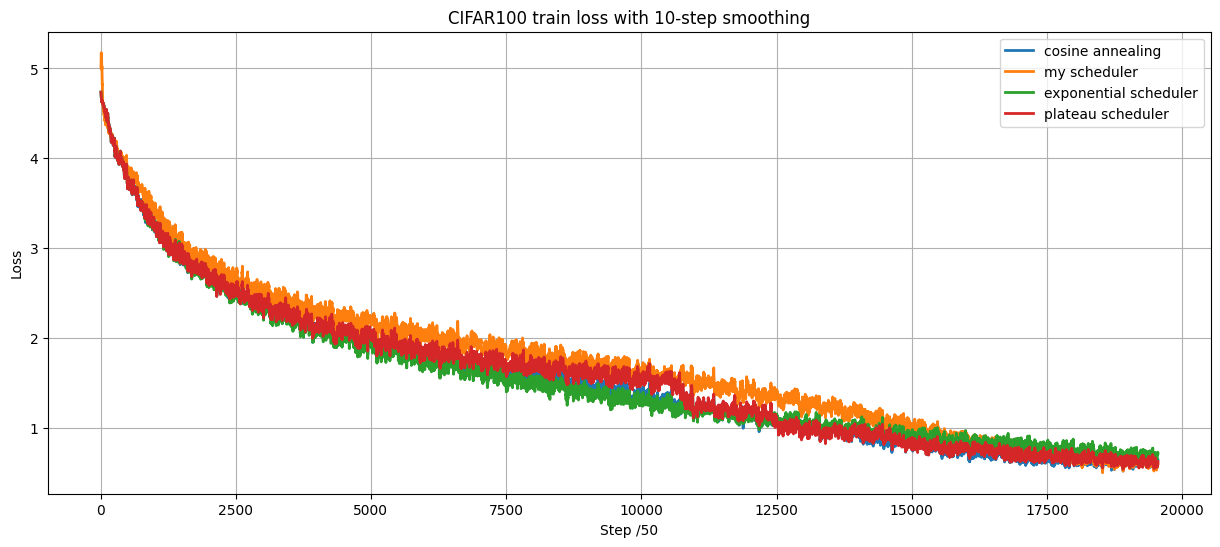

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
N_roll = 10

x = list(range(len(losses["cosine"])))

plt.figure(figsize=(15, 6))

plt.plot(x, pd.Series(losses["cosine"]).rolling(window=N_roll).mean(), marker='', linestyle='-', linewidth=2, label='cosine annealing')
plt.plot(x, pd.Series(losses["gbm"]).rolling(window=N_roll).mean(),  marker='', linestyle='-', linewidth=2, label='my scheduler')
plt.plot(x, pd.Series(losses["exp"]).rolling(window=N_roll).mean(),  marker='', linestyle='-', linewidth=2, label='exponential scheduler')
plt.plot(x, pd.Series(losses["plateau"]).rolling(window=N_roll).mean(),  marker='', linestyle='-', linewidth=2, label='plateau scheduler')

plt.xlabel("Step /50")
plt.ylabel("Loss")
plt.title("CIFAR100 train loss with 10-step smoothing")
plt.legend()
plt.grid(True)
plt.show()


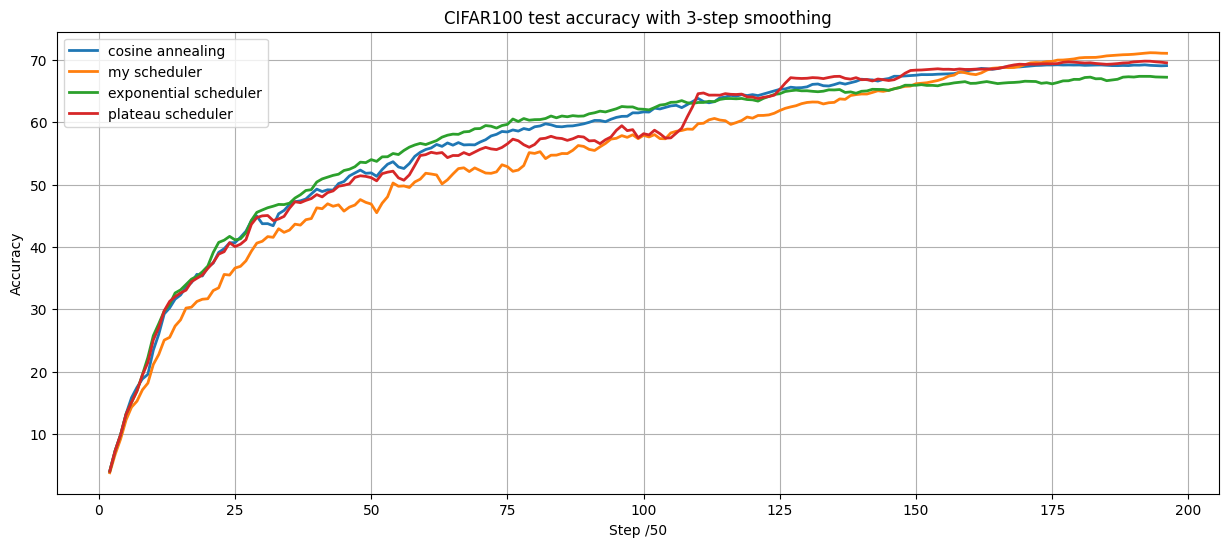

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
N_roll = 3

x = list(range(len(accs["cosine"])))

plt.figure(figsize=(15, 6))

plt.plot(x, pd.Series(accs["cosine"]).rolling(window=N_roll).mean(), marker='', linestyle='-', linewidth=2, label='cosine annealing')
plt.plot(x, pd.Series(accs["gbm"]).rolling(window=N_roll).mean(),  marker='', linestyle='-', linewidth=2, label='my scheduler')
plt.plot(x, pd.Series(accs["exp"]).rolling(window=N_roll).mean(),  marker='', linestyle='-', linewidth=2, label='exponential scheduler')
plt.plot(x, pd.Series(accs["plateau"]).rolling(window=N_roll).mean(),  marker='', linestyle='-', linewidth=2, label='plateau scheduler')

plt.xlabel("Step /50")
plt.ylabel("Accuracy")
plt.title("CIFAR100 test accuracy with 3-step smoothing")
plt.legend()
plt.grid(True)
plt.show()
